In [19]:
import pandas as pd
df = pd.read_csv("google_clean.csv")  # Make sure file name is correct
df.columns = df.columns.str.strip().str.lower()
df['volume_prev'] = df['volume'].shift(1)
df['volatility_prev'] = df['volatility'].shift(1)
df['volume_delta'] = df['volume'] - df['volume_prev']
df['volatility_delta'] = df['volatility'] - df['volatility_prev']
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])

df.head()


,date,open,high,low,close,adj close,volume,volatility,volume_prev,volatility_prev,volume_delta,volatility_delta
1,2020-12-07,90.95,91.62,90.29,90.97,90.36,26418000.0,0.014620,27564000.0,0.008862,-1146000.0,0.005758
2,2020-12-08,90.50,91.10,89.81,90.93,90.31,21926000.0,0.014187,26418000.0,0.014620,-4492000.0,-0.000433
3,2020-12-09,90.60,91.71,88.39,89.21,88.60,30152000.0,0.037216,21926000.0,0.014187,8226000.0,0.023029
4,2020-12-10,88.49,89.07,87.02,88.77,88.16,27256000.0,0.023093,30152000.0,0.037216,-2896000.0,-0.014122
5,2020-12-11,88.15,89.22,88.00,89.09,88.48,24414000.0,0.013694,27256000.0,0.023093,-2842000.0,-0.009399


In [13]:
df['volume_delta'] = df['volume'] - df['volume_prev']
df['volatility_delta'] = df['volatility'] - df['volatility_prev']


In [14]:
# Prepare feature (X) and target (y)
volume_changes = df['volume_delta'].values.reshape(-1, 1)
volatility_changes = df['volatility_delta'].values


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Train Linear Model
linear_model = LinearRegression()
linear_model.fit(volume_changes, volatility_changes)

linear_predictions = linear_model.predict(volume_changes)

linear_r2 = r2_score(volatility_changes, linear_predictions)

slope = linear_model.coef_[0]
intercept = linear_model.intercept_

print("----- GOOG: LINEAR MODEL -----")
print(f"R² Score: {linear_r2:.4f} ({linear_r2*100:.2f}%)")
print(f"Equation: Δσ = {slope:.6e} × ΔV + {intercept:.6e}")


----- GOOG: LINEAR MODEL -----
R² Score: 0.2533 (25.33%)
Equation: Δσ = 6.090351e-10 × ΔV + 2.989960e-06


In [16]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial Features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(volume_changes)

# Train Model
poly_model = LinearRegression()
poly_model.fit(X_poly, volatility_changes)

poly_predictions = poly_model.predict(X_poly)

# R² Score
r2_poly = r2_score(volatility_changes, poly_predictions)

print("\n----- GOOG: POLYNOMIAL MODEL (Degree 2) -----")
print(f"R² Score: {r2_poly:.4f} ({r2_poly*100:.2f}%)")



----- GOOG: POLYNOMIAL MODEL (Degree 2) -----
R² Score: 0.2541 (25.41%)


In [17]:
print("\n----- GOOG: MODEL COMPARISON -----")
print(f"Linear Model R²:     {linear_r2:.4f}")
print(f"Polynomial Model R²: {r2_poly:.4f}")

improvement = r2_poly - linear_r2

print(f"\nImprovement: {improvement:.4f} ({improvement*100:.2f}%)")

if r2_poly > linear_r2:
    print(f"\nPolynomial model is better by {improvement*100:.2f}%")
else:
    print("\nLinear model is actually better for GOOG.")



----- GOOG: MODEL COMPARISON -----
Linear Model R²:     0.2533
Polynomial Model R²: 0.2541

Improvement: 0.0008 (0.08%)

Polynomial model is better by 0.08%


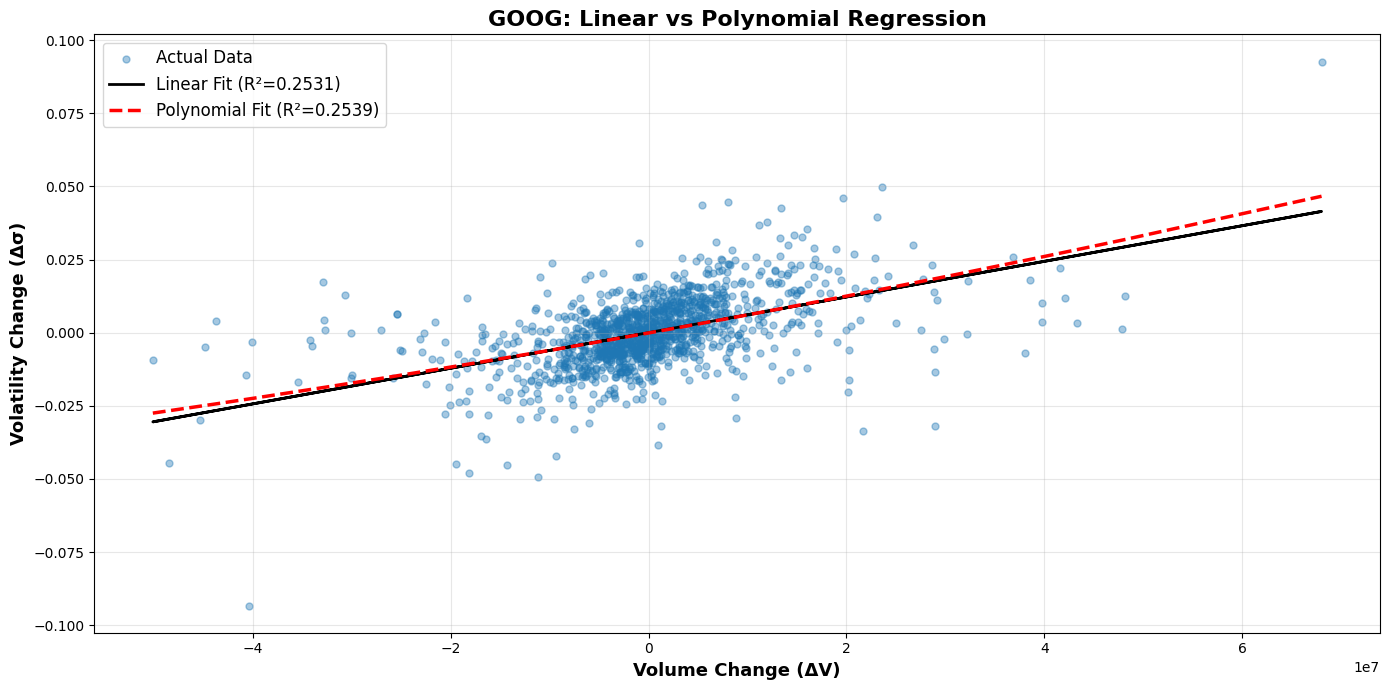

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Scatter Plot
plt.scatter(
    volume_changes, volatility_changes,
    alpha=0.4, s=25, color='#1f77b4',
    label='Actual Data'
)

# Linear Fit
plt.plot(
    volume_changes, linear_predictions,
    color='black', linewidth=2,
    label=f'Linear Fit (R²={linear_r2:.4f})'
)

# Prepare sorted X for polynomial curve
sorted_idx = np.argsort(volume_changes.flatten())

# Polynomial Fit
plt.plot(
    volume_changes[sorted_idx], poly_predictions[sorted_idx],
    color='red', linewidth=2.5, linestyle='--',
    label=f'Polynomial Fit (R²={r2_poly:.4f})'
)

plt.xlabel('Volume Change (ΔV)', fontsize=13, fontweight='bold')
plt.ylabel('Volatility Change (Δσ)', fontsize=13, fontweight='bold')
plt.title('GOOG: Linear vs Polynomial Regression', fontsize=16, fontweight='bold')

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
